In [1]:

import numpy as np
import pandas as pd
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn import metrics
from collections import Counter
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.sklearn import metrics
#from common_utils import compute_metrics

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]



#Load the data
titanic_data = pd.read_csv('C:/Users/thano/Υπολογιστής/ΠΤΥΧΙΑΚΗ/DATASETS/titanic.csv',sep= ',', header= 0)

In [2]:
print ("Dataset Lenght:: ", len(titanic_data))
print ("Dataset Shape:: ", titanic_data.shape)
#titanic_data.sample(50)


print ("Rows     : " ,titanic_data.isnull().shape[0])
print ("Columns  : " ,titanic_data.isnull().shape[1])
print ("\nMissing values :  ", titanic_data.isnull().sum().values.sum())



Dataset Lenght::  891
Dataset Shape::  (891, 12)
Rows     :  891
Columns  :  12

Missing values :   866


In [3]:
#replace ? with NaN
titanic_data = titanic_data.replace('?', np.nan)
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_check_missing = (titanic_data.isnull()).sum()
titanic_check_missing

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
#delete columns with missing values
titanic_data = titanic_data.drop("Cabin", axis =1)
titanic_data = titanic_data.drop("Embarked", axis =1)
titanic_data = titanic_data.drop("Age", axis =1)

In [6]:
# rename the other values except class =1 value in Pclass column for SPD computation
titanic_data['Pclass']= titanic_data['Pclass'].replace([2,3], 2.3)
titanic_data.head(20)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare
0,1,0,2.3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500
1,2,1,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833
2,3,1,2.3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250
3,4,1,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000
4,5,0,2.3,"Allen, Mr. William Henry",male,0,0,373450,8.0500
5,6,0,2.3,"Moran, Mr. James",male,0,0,330877,8.4583
6,7,0,1.0,"McCarthy, Mr. Timothy J",male,0,0,17463,51.8625
7,8,0,2.3,"Palsson, Master. Gosta Leonard",male,3,1,349909,21.0750
8,9,1,2.3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,0,2,347742,11.1333
9,10,1,2.3,"Nasser, Mrs. Nicholas (Adele Achem)",female,1,0,237736,30.0708


In [ ]:
#plot the categorical count of each protected category
lis2 = ['Pclass', 'Sex']
plt.subplots(figsize=(10, 5))
index = 1
  
for col in lis2:
    y = titanic_data[col].value_counts()
    plt.subplot(1, 2, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1

In [7]:
# select all categorical variables
titanic_data_categorical = titanic_data.select_dtypes(include=['object'])
titanic_data_categorical.head()

,Name,Sex,Ticket
0,"Braund, Mr. Owen Harris",male,A/5 21171
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803
4,"Allen, Mr. William Henry",male,373450


In [8]:
# apply Label Encoder to categorical values
le = preprocessing.LabelEncoder()
titanic_data_categorical = titanic_data_categorical.apply(le.fit_transform)
titanic_data_categorical.head()

,Name,Sex,Ticket
0,108,1,523
1,190,0,596
2,353,0,669
3,272,0,49
4,15,1,472


In [9]:
#first, Drop earlier duplicate columns which had categorical values and concat eith new labelled categories (mean-mode function)
#titanic_data_mode = titanic_mode.drop(titanic_data_categorical.columns,axis=1)
#titanic_data_mode = pd.concat([titanic_data_mode,titanic_data_categorical],axis=1)
#titanic_data_mode.head(10)

#first, Drop earlier duplicate columns which had categorical values and concat eith new labelled categories (cd function)
titanic_data = titanic_data.drop(titanic_data_categorical.columns,axis=1)
titanic_data = pd.concat([titanic_data,titanic_data_categorical],axis=1)
titanic_data.head(10)

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Name,Sex,Ticket
0,1,0,2.3,1,0,7.2500,108,1,523
1,2,1,1.0,1,0,71.2833,190,0,596
2,3,1,2.3,0,0,7.9250,353,0,669
3,4,1,1.0,1,0,53.1000,272,0,49
4,5,0,2.3,0,0,8.0500,15,1,472
5,6,0,2.3,0,0,8.4583,554,1,275
6,7,0,1.0,0,0,51.8625,515,1,85
7,8,0,2.3,3,1,21.0750,624,1,395
8,9,1,2.3,0,2,11.1333,412,0,344
9,10,1,2.3,1,0,30.0708,576,0,132


In [20]:
titanic_data1 = titanic_data.drop(['Survived'], axis=1)
titanic_data = pd.concat([titanic_data1,titanic_data['Survived']],axis=1)
#adult_data = pd.concat([adult_data,adult_data_categorical],axis=1)
titanic_data.head()

,PassengerId,Pclass,SibSp,Parch,Fare,Name,Sex,Ticket,Survived
0,1,2.3,1,0,7.2500,108,1,523,0
1,2,1.0,1,0,71.2833,190,0,596,1
2,3,2.3,0,0,7.9250,353,0,669,1
3,4,1.0,1,0,53.1000,272,0,49,1
4,5,2.3,0,0,8.0500,15,1,472,0


In [10]:
#Pearson correlations
pearson = titanic_data.corr(method = 'pearson')
pearson

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Name,Sex,Ticket
PassengerId,1.000000,-0.005007,-0.034303,-0.057527,-0.001652,0.012658,-0.038559,0.042939,-0.056554
Survived,-0.005007,1.000000,-0.285904,-0.035322,0.081629,0.257307,-0.057343,-0.543351,-0.164549
Pclass,-0.034303,-0.285904,1.000000,0.054582,0.017633,-0.591711,0.039659,0.098013,0.261896
SibSp,-0.057527,-0.035322,0.054582,1.000000,0.414838,0.159651,-0.017230,-0.114631,0.079461
Parch,-0.001652,0.081629,0.017633,0.414838,1.000000,0.216225,-0.049105,-0.245489,0.020003
Fare,0.012658,0.257307,-0.591711,0.159651,0.216225,1.000000,-0.049173,-0.182333,-0.013885
Name,-0.038559,-0.057343,0.039659,-0.017230,-0.049105,-0.049173,1.000000,0.020314,0.047348
Sex,0.042939,-0.543351,0.098013,-0.114631,-0.245489,-0.182333,0.020314,1.000000,0.059372
Ticket,-0.056554,-0.164549,0.261896,0.079461,0.020003,-0.013885,0.047348,0.059372,1.000000


<AxesSubplot:>

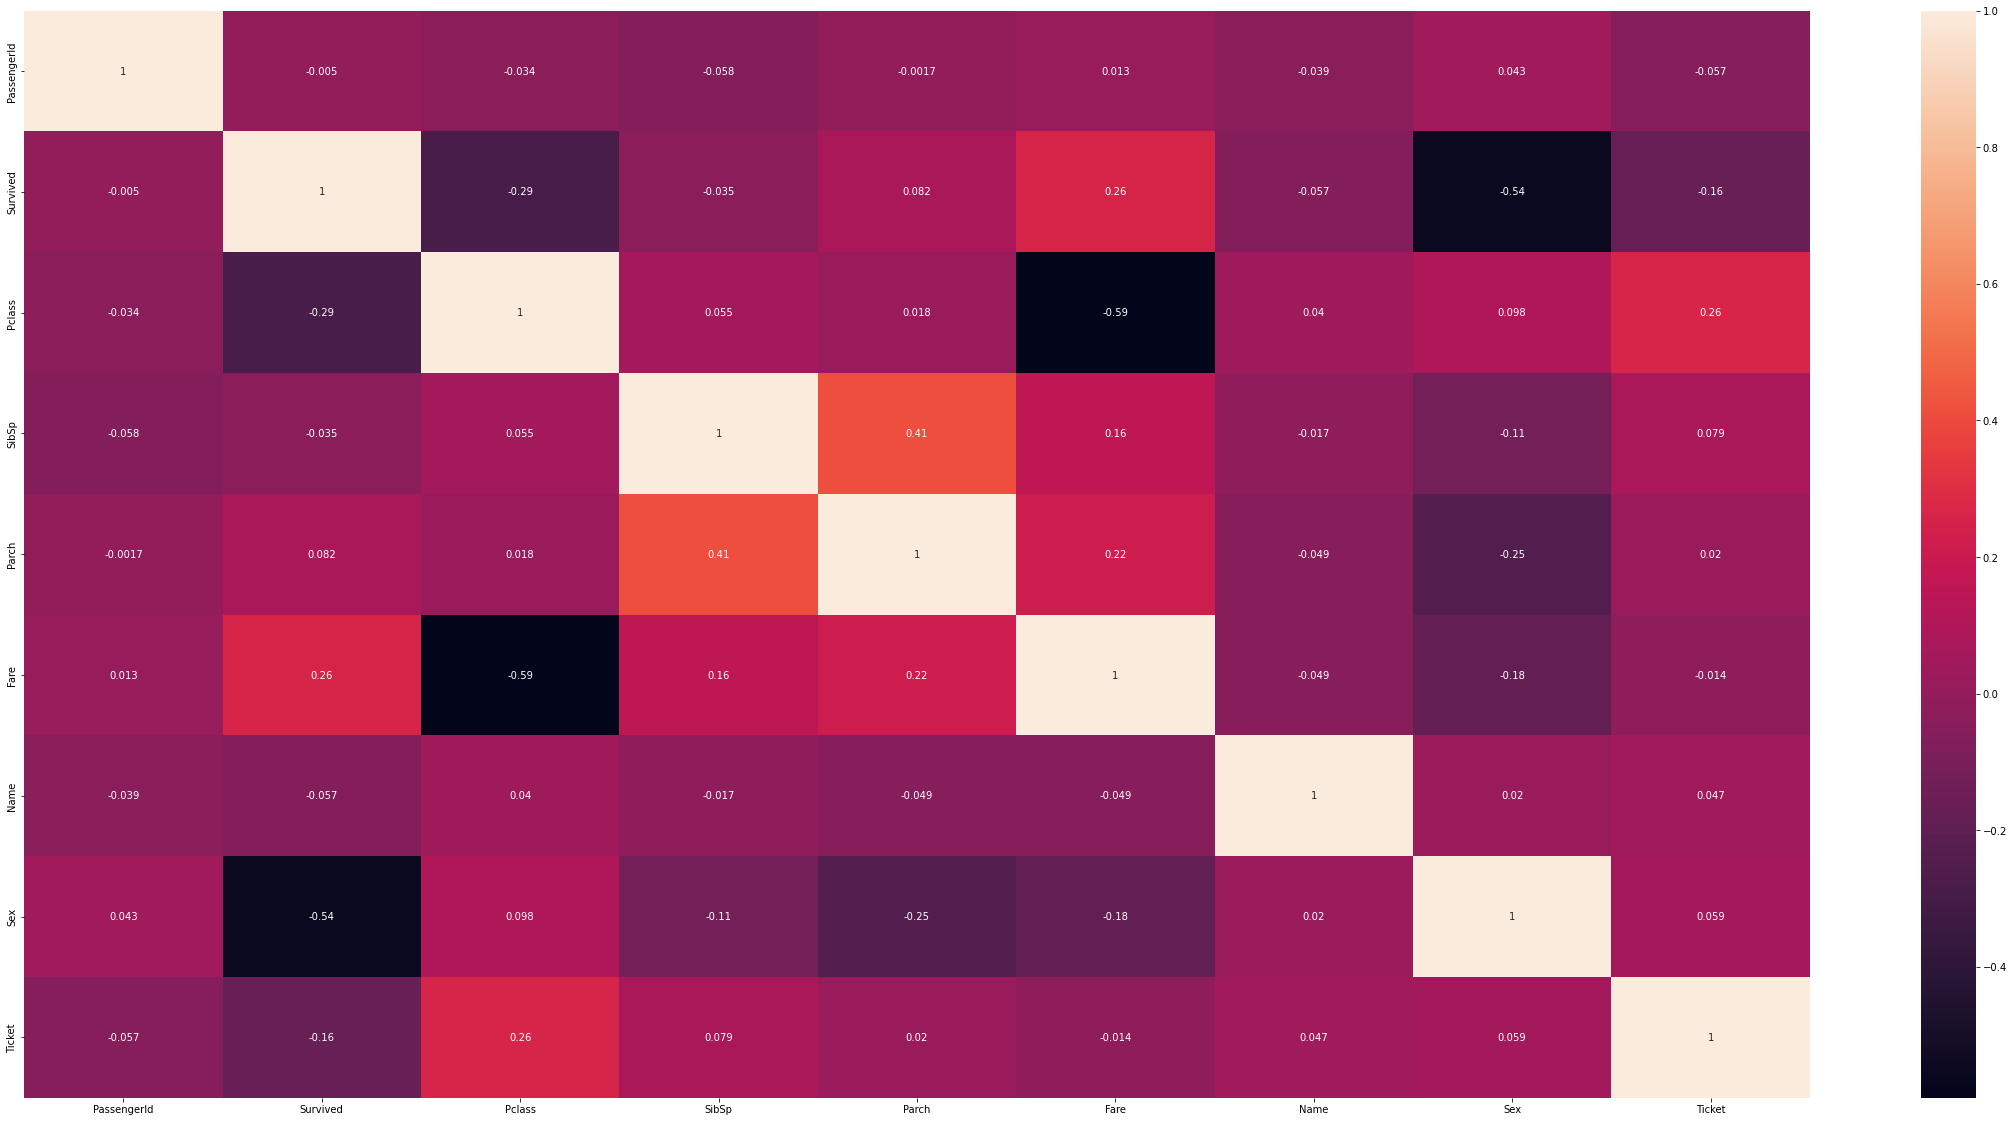

In [11]:
#create Heatmap 
plt.figure(figsize = (40,20))
sns.heatmap(pearson, annot = True)

In [12]:
target = titanic_data.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=523, Count=1, Percentage=0.112%
Class=596, Count=1, Percentage=0.112%
Class=669, Count=1, Percentage=0.112%
Class=49, Count=2, Percentage=0.224%
Class=472, Count=1, Percentage=0.112%
Class=275, Count=1, Percentage=0.112%
Class=85, Count=1, Percentage=0.112%
Class=395, Count=4, Percentage=0.449%
Class=344, Count=3, Percentage=0.337%
Class=132, Count=2, Percentage=0.224%
Class=616, Count=2, Percentage=0.224%
Class=38, Count=1, Percentage=0.112%
Class=535, Count=1, Percentage=0.112%
Class=333, Count=7, Percentage=0.786%
Class=413, Count=1, Percentage=0.112%
Class=153, Count=1, Percentage=0.112%
Class=480, Count=5, Percentage=0.561%
Class=151, Count=1, Percentage=0.112%
Class=301, Count=1, Percentage=0.112%
Class=184, Count=1, Percentage=0.112%
Class=139, Count=2, Percentage=0.224%
Class=152, Count=1, Percentage=0.112%
Class=278, Count=1, Percentage=0.112%
Class=42, Count=1, Percentage=0.112%
Class=329, Count=4, Percentage=0.449%
Class=179, Count=1, Percentage=0.112%
Class=95, Count=

In [13]:
# convert target variable Survived to categorical
titanic_data['Survived'] = titanic_data['Survived'].astype('category')

In [14]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Pclass       891 non-null    float64 
 3   SibSp        891 non-null    int64   
 4   Parch        891 non-null    int64   
 5   Fare         891 non-null    float64 
 6   Name         891 non-null    int32   
 7   Sex          891 non-null    int32   
 8   Ticket       891 non-null    int32   
dtypes: category(1), float64(2), int32(3), int64(3)
memory usage: 46.4 KB


In [21]:
#MinMax scalling
scaler = MinMaxScaler()
scaled = scaler.fit_transform(titanic_data)
#X_test_scaled = scaler.transform(X_test)


In [22]:
titanic = pd.DataFrame(scaled,columns = titanic_data.columns)
#titanic = pd.DataFrame(X_test,  columns = ["age","education","education.num","marital.status","relationship","race","Sex","capital.gain","capital.loss","hours.per.week"])
titanic.head(20)                    

,PassengerId,Pclass,SibSp,Parch,Fare,Name,Sex,Ticket,Survived
0,0.000000,1.0,0.125,0.000000,0.014151,0.121348,1.0,0.769118,0.0
1,0.001124,0.0,0.125,0.000000,0.139136,0.213483,0.0,0.876471,1.0
2,0.002247,1.0,0.000,0.000000,0.015469,0.396629,0.0,0.983824,1.0
3,0.003371,0.0,0.125,0.000000,0.103644,0.305618,0.0,0.072059,1.0
4,0.004494,1.0,0.000,0.000000,0.015713,0.016854,1.0,0.694118,0.0
5,0.005618,1.0,0.000,0.000000,0.016510,0.622472,1.0,0.404412,0.0
6,0.006742,0.0,0.000,0.000000,0.101229,0.578652,1.0,0.125000,0.0
7,0.007865,1.0,0.375,0.166667,0.041136,0.701124,1.0,0.580882,0.0
8,0.008989,1.0,0.000,0.333333,0.021731,0.462921,0.0,0.505882,1.0
9,0.010112,1.0,0.125,0.000000,0.058694,0.647191,0.0,0.194118,1.0


In [24]:
titanic['Survived']= titanic['Survived'].apply(np.int64)

In [59]:
# Putting independent variables/features to X
X = titanic.drop('Survived',axis=1)
# Putting response/dependent variable/feature to y
y = titanic['Survived']


In [25]:
titanic.head()

,PassengerId,Pclass,SibSp,Parch,Fare,Name,Sex,Ticket,Survived
0,0.000000,1.0,0.125,0.0,0.014151,0.121348,1.0,0.769118,0
1,0.001124,0.0,0.125,0.0,0.139136,0.213483,0.0,0.876471,1
2,0.002247,1.0,0.000,0.0,0.015469,0.396629,0.0,0.983824,1
3,0.003371,0.0,0.125,0.0,0.103644,0.305618,0.0,0.072059,1
4,0.004494,1.0,0.000,0.0,0.015713,0.016854,1.0,0.694118,0


In [65]:
# Splitting the data into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

privileged_groups = [{'Sex' :1}]
unprivileged_groups = [{'Sex' :0}]

privileged_groups = [{'Pclass' :1}]
unprivileged_groups = [{'Pclass' : 0}]

In [28]:
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= titanic,
    label_names = ['Survived'],
    protected_attribute_names=['Sex'])

In [29]:
#SPD without classification
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
# Load and create explainers

text_exp_otr = MetricTextExplainer(metric_orig_train)
# Print statistical parity difference
print(text_exp_otr.statistical_parity_difference())

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 0.5531300709799203


In [30]:
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Staistical Parity Difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Staistical Parity Difference between unprivileged and privileged groups = 0.553130


In [31]:
# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is the best each time
from sklearn.model_selection import GridSearchCV
tree_param = {'criterion':['gini','entropy'],'max_depth':range(2,20)}
dt_default = GridSearchCV(DecisionTreeClassifier(), tree_param)
dt_default.fit(X_train,y_train)

print('Best score: {}'.format(dt_default.best_score_))
print('Best parameters: {}'.format(dt_default.best_params_))


Best score: 0.7948939512961508
Best parameters: {'criterion': 'entropy', 'max_depth': 7}


In [32]:
#find the best parameters for the classifier and fit it to the data 
dt_best = DecisionTreeClassifier(criterion= 'entropy', max_depth= 7)
dt_best.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [33]:
# making predictions
y_pred_default = dt_best.predict(X_test)
y_pred_default.shape

(223,)

In [34]:
# Printing classifier report after prediction
from sklearn import metrics
accuracy_scorer = metrics.make_scorer(metrics.accuracy_score)
print("\nAccuracy Score is: " + str(metrics.accuracy_score(y_test, y_pred_default)))


Accuracy Score is: 0.726457399103139


In [ ]:
#Stratified K-fold 
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
lst_accu_stratified = []

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = dt_default[train_index], dt_default[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    lr.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(lr.score(x_test_fold, y_test_fold))

In [ ]:
#true negatives and true positives
tpr=np.sum((y_pred_default.ravel()==1)*(y_test.ravel()==1)) / np.sum(y_pred_default.ravel()==1)
tnr=np.sum((y_pred_default.ravel()==0)*(y_test.ravel()==0)) / np.sum(y_pred_default.ravel()==0)
# Printing accuracy
print("Accuracy score=",accuracy_score(y_test,y_pred_default))
print("True positive rate =",tpr)  
print("True negative rate =",tnr)

In [35]:
X_test = pd.concat([X_test,y_test],axis=1)
X_test

,PassengerId,Pclass,SibSp,Parch,Fare,Name,Sex,Ticket,Survived
555,0.623596,0.0,0.000,0.000000,0.051822,0.982022,1.0,0.076471,0
556,0.624719,0.0,0.125,0.000000,0.077294,0.256180,0.0,0.083824,1
810,0.910112,1.0,0.000,0.000000,0.015395,0.011236,1.0,0.498529,0
323,0.362921,1.0,0.125,0.166667,0.056604,0.143820,0.0,0.232353,1
205,0.230337,1.0,0.000,0.166667,0.020421,0.886517,0.0,0.464706,0
...,...,...,...,...,...,...,...,...,...
380,0.426966,0.0,0.000,0.000000,0.444099,0.096629,0.0,0.897059,1
179,0.201124,1.0,0.000,0.000000,0.000000,0.532584,1.0,0.844118,0
550,0.617978,0.0,0.000,0.333333,0.216430,0.903371,1.0,0.122059,1
47,0.052809,1.0,0.000,0.000000,0.015127,0.678652,0.0,0.111765,1


In [36]:
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= X_test,
    label_names=['Survived'],
    protected_attribute_names=['Sex'])

In [37]:
from aif360.metrics import BinaryLabelDatasetMetric

def fair_metrics(binaryLabelDataset, y_pred_default):
    dataset_pred = binaryLabelDataset.copy()
    dataset_pred.labels = y_pred_default
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference()}
        
    return result


fair_metrics(binaryLabelDataset, y_pred_default)

{'statistical_parity_difference': 0.5129973474801061}

In [38]:
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Staistical Parity Difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Staistical Parity Difference between unprivileged and privileged groups = 0.512025


In [40]:
# list of models
models = [LogisticRegression(max_iter=500), SVC(kernel='linear'), KNeighborsClassifier(), RandomForestClassifier(), GaussianNB()]

In [68]:
#function for comparing the accuracy of 4 classifiers after 10-fold cross validation
def compare_models_cross_validation():

  for model in models:

    cv_score = cross_val_score(model, X,y, cv=5)
    
    mean_accuracy = sum(cv_score)/len(cv_score)

    mean_accuracy = mean_accuracy*100

    mean_accuracy = round(mean_accuracy, 2)

    print('Cross Validation accuracies for ', model, '=  ', cv_score)
    print('Accuracy % of the ', model, mean_accuracy )
    print('----------------------------------------------')

In [69]:
#Execute the function
compare_models_cross_validation()

Cross Validation accuracies for  LogisticRegression(max_iter=500) =   [0.80446927 0.76404494 0.78089888 0.75280899 0.80898876]
Accuracy % of the  LogisticRegression(max_iter=500) 78.22
----------------------------------------------
Cross Validation accuracies for  SVC(kernel='linear') =   [0.80446927 0.80337079 0.78651685 0.75280899 0.78651685]
Accuracy % of the  SVC(kernel='linear') 78.67
----------------------------------------------
Cross Validation accuracies for  KNeighborsClassifier() =   [0.77094972 0.75280899 0.79213483 0.76966292 0.78089888]
Accuracy % of the  KNeighborsClassifier() 77.33
----------------------------------------------
Cross Validation accuracies for  RandomForestClassifier() =   [0.75418994 0.81460674 0.84269663 0.82022472 0.80898876]
Accuracy % of the  RandomForestClassifier() 80.81
----------------------------------------------
Cross Validation accuracies for  GaussianNB() =   [0.75977654 0.75280899 0.76404494 0.78651685 0.79775281]
Accuracy % of the  Gaussi

In [66]:
#Train with the best classifier based on accuracy
from sklearn import model_selection
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [70]:
# Printing classifier report after prediction
from sklearn import metrics
accuracy_scorer = metrics.make_scorer(metrics.accuracy_score)
print("\nAccuracy Score is: " + str(metrics.accuracy_score(y_test, rfc_predict)))


Accuracy Score is: 0.7892376681614349


In [71]:
X_test = pd.concat([X_test,y_test],axis=1)
X_test

,PassengerId,Pclass,SibSp,Parch,Fare,Name,Sex,Ticket,Survived
680,0.764045,1.0,0.000,0.000000,0.015883,0.735955,0.0,0.413235,0
74,0.083146,1.0,0.000,0.000000,0.110272,0.097753,1.0,0.117647,1
393,0.441573,0.0,0.125,0.000000,0.221098,0.655056,0.0,0.611765,1
883,0.992135,1.0,0.000,0.000000,0.020495,0.068539,1.0,0.830882,0
563,0.632584,1.0,0.000,0.000000,0.015713,0.838202,1.0,0.957353,0
...,...,...,...,...,...,...,...,...,...
446,0.501124,1.0,0.000,0.166667,0.038061,0.594382,0.0,0.238235,1
2,0.002247,1.0,0.000,0.000000,0.015469,0.396629,0.0,0.983824,1
145,0.162921,1.0,0.125,0.166667,0.071731,0.658427,1.0,0.820588,0
707,0.794382,0.0,0.000,0.000000,0.051310,0.141573,1.0,0.852941,1


In [72]:
binaryLabelDataset3 = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= X_test,
    label_names=['Survived'],
    protected_attribute_names=['Sex'])

In [73]:
from aif360.metrics import BinaryLabelDatasetMetric

def fair_metrics(binaryLabelDataset3, rfc_predict):
    dataset_pred = binaryLabelDataset3.copy()
    dataset_pred.labels = rfc_predict
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference()}
        
    return result


fair_metrics(binaryLabelDataset3, rfc_predict)

{'statistical_parity_difference': 0.7161308840413318}